In [1]:
# 2022年6月28日09:21:47
# 导入模块
import time
import pdfplumber as pp
from functools import reduce
from operator import add
from PIL import Image
import numpy as np
# import pytesseract # replace pytesseract module with paddleocr, to make identification faster.
from paddleocr import PaddleOCR, draw_ocr
import os


In [2]:

class Pdf2txt:
    
    # 初始化参数
    def __init__(self,pdfpath,csvfile):
        self.pdfpath = pdfpath
        self.csvfile = csvfile
        self.text = ''
        self.ocr = PaddleOCR(use_angle_cls = True, use_gpu = False) # replace with paddleocr
        print('Pdf2txt Class is initiated!')
    
    # padding image, 给图像增加白边
    def pad_img(self,image, padding_num):    # image is an object of image, padding_num 就是要在图像边缘增加几个像素
        iw, ih = image.size # 原图像尺寸
        w,h = iw + 2 * padding_num, ih + 2 * padding_num
        # print('iw:',iw,'ih:',ih)
        # print('w:',w,'h',h,'padding:',padding_num)
        new_image = Image.new('RGB',(w,h),(256,256,256))
        new_image.paste(image,((w - iw)//2,(h - ih) // 2))
        return new_image

#     def img2txt(self,i_tmp):  # i_tmp is a dict of image in pdf
#         # pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
        
#         imgstream = i_tmp['stream']
#         if i_tmp['height']<19:
#             data = imgstream.get_data()
#             # imgrawdata = imgstream.rawdata
#             # print(imgrawdata)
#             size = (imgstream.attrs['Width'], imgstream.attrs['Height'])
#             if imgstream.attrs['ColorSpace'].name == 'DeviceRGB':
#                 mode = 'RGB'
#             else:
#                 mode = 'P'
#             img_pre = "F:/工作/2022/05/lzk/imgs/" + str(int(time.time()*1000))# i_tmp['name']
#             # print(imgstream.attrs['Filter'].name)
#             FilterName = imgstream.attrs['Filter'].name
#             if 'Filter' in imgstream.attrs:
#                 if FilterName == 'FlateDecode':
#                     # print("Flate")
#                     img = Image.frombytes(mode, size, data)
#                     img = self.pad_img(img,20)
#                     # content = pytesseract.image_to_string(img, lang='eng+chi_sim')
#                     img_np = np.array(img)
#                     try:
#                         result = self.ocr.ocr(img_np,cls = True)
#                         content = result[0][1][0]
#                     except:
#                         content = 'ocrError'
#                     content = content.replace(' ','') # 去掉空格
#                     content = content.replace('\n','') # 去掉换行符
#                     content = content + ''
#                     if content == '':
#                         return ""
#                     else:
#                         return content
#                     # img.save(img_pre + ".png", dpi=(300,300))
#                 elif FilterName == 'DCTDecode':
#                     # # print("DCT")
#                     # img = open(img_pre + ".jpg", "wb")
#                     # img.write(data)
#                     # img.close()
#                     return ""
#                 elif FilterName == 'JPXDecode':
#                     # img = open(img_pre + ".jp2", "wb")
#                     # img.write(data)
#                     # img.close()
#                     return ""
#                 elif FilterName == 'CCITTFaxDecode':
#                     # img = open(img_pre + ".tiff", "wb")
#                     # img.write(data)
#                     # img.close()
#                     return ""
#                 elif FilterName == "JBIG2Decode":
#                     img = open(img_pre + ".jb2", "wb")
#                     img.write(data)
#                     img.close()
#             else:
#                 return   ""
#         else:
#             return '\n'
    
    def img2txt(self,pageimg,obimg):
        # pageimg is an image object, pageimg = page.to_image(resolution = 300)
        # obimg is an image object, type of obimg is dict
        x0 = obimg['x0']; x1 = obimg['x1']; y0 = obimg['y0']; y1 = obimg['y1']
        print('x0:',x0,'y0:',y0,'x1:',x1,'y1:',y1)
        
        return 'test0'

    # 根据排序后的list结果，返回文本顺序
    def oblist2txt(self,oball):
        oba = oball
        oba.sort(key = lambda x:x['y0']+x['y1'], reverse = True)
        obtext = ''
        line = []
        ii = -1
        while(len(oba) > 0):
            ob0 = oba[0]
            ii = ii + 1
            if ii ==0:
                line.append(ob0)
                # y0 = ob[0]['y0']
                oba.remove(ob0)
                
                # print('line:test')
            else:
                if(len(oba) > 1):
                    ob1 = oba[1]
                    ob0center = ob0['y1'] + ob0['y0']
                    ob1center = ob1['y1'] + ob1['y0']
                    if(ob0center - ob1center < 5):
                        line.append(ob0)
                        oba.remove(ob0)
                    else:
                        line.append(ob0)
                        oba.remove(ob0)
                        obtext = obtext.join(self.sortline(line))
                        ii = -1
                        line = []                    
                else:
                    break # 最后面一个元素是‘本结果仅对所做标本负责’ pass 
        return obtext


    # 将一行字典列表转成为文本，间隔远的字符间加逗号
    def sortline(self,line):
        txt =''
        line.sort(key = lambda x:x['x0']+x['x1'], reverse = False)
        ii = 0
        while(len(line) >0):
            # if line[0]['text'] == '：':
            #     line[0]['text'] = '：,'
            if ii == 0:
                txt = line[0]['text']
                line.remove(line[0])
                ii = ii + 1
            else:
                if(len(line) > 1):
                    # 如果相距远，加逗号
                    if line[1]['x0'] - line[0]['x1'] > 1:
                        txt = txt + line[0]['text'] + ','
                        line.remove(line[0])
                    # 如果后一个字符盖着前一个字符一半，加逗号
                    elif line[0]['x1']-line[1]['x0']> 0.2:
                        txt = txt + line[0]['text'] + ','
                        line.remove(line[0])
                    else: # if line[1]['x0'] - line[0]['x1'] >= 0:
                        txt = txt + line[0]['text']
                        line.remove(line[0])
                    # elif line[1]['x0'] - line[0]['x1'] < 0:
                else:
                    txt = txt.join(line[0]['text'])
                    break
        
        txt = txt + '\n' # 末尾加换行
        return txt

    def pdf2txt(self): 
        print(self.pdfpath)
        # 读取一个pdf, 获取image和char对象
        pdf = pp.open(self.pdfpath)  # 打开pdf
        pages =  pdf.pages  # 获取指定页面
        for page in pages:
            ob = page.objects
            ob_char = ob['char']
            ob_image = ob['image']
            # pageimg = page.to_image(resolution = 300)
            # print(len(ob_image),'--',type(ob_image))
            # print(len(ob_char),'--',type(ob_char))

            ii = 0
            for ob in ob_image:
                ob_image[ii]['text'] = self.img2txt(pageimg,ob)
                print('imgtxt:',ob_image[ii]['text'])
                ii = ii + 1
            oba=[]
            oba.extend(ob_char)
            oba.extend(ob_image)
            # print(len(oba),'--',type(oba))
            self.text = self.text.join(self.oblist2txt(oba)) 
    
    def writetext2csv(self):
        file = open(self.csvfile,'a+',encoding='utf-8')
        file.write(self.text)
        file.close
        print("file is written.")


In [5]:
file_path = './tmp/t1/0001186421.pdf' # PDF 文件路径
dir_path = './imgs/' # 存放图片的文件夹

In [3]:
# from wand.image import Image
# 安装了MagickWand 和 ghostscript之后就可以使用PageImage.to_image()了

In [6]:
test = Pdf2txt(file_path,'')

[2022/06/28 20:42:53] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\wang_/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_fce_box_type='poly', det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\wang_/.paddleocr/whl\\det\\ch\\ch_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='quad', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_

In [ ]:
test.pdf2txt()

In [8]:
pdf = pp.open(file_path)
page = pdf.pages[0]

In [15]:
pgimg = page.to_image(resolution=300)
print(page.width,page.height)

595.276 841.89


In [12]:
import matplotlib.pyplot as plt


In [33]:
print(type(pgimg))
pgimg.save("./pgimg300.png", format = "PNG")

<class 'pdfplumber.display.PageImage'>


In [17]:
pw = page.width; ph = page.height

In [32]:
from PIL import Image
import matplotlib.pyplot as plt
pilimg = Image.open("./pgimg300.png")
# plt.imshow(pilimg)
iw = pilimg.size[0]; ih = pilimg.size[1]
print(iw,ih)
print(iw/pw,ih/ph)

2480 3508
4.16613470054227 4.166815142120704


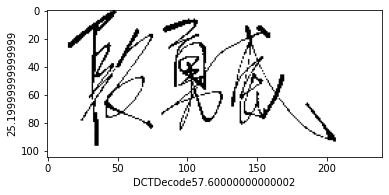

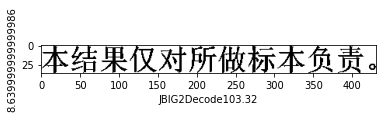

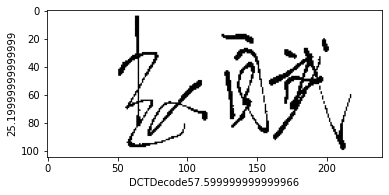

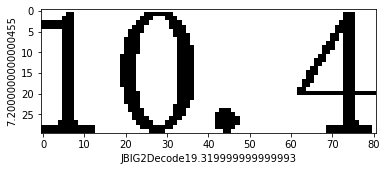

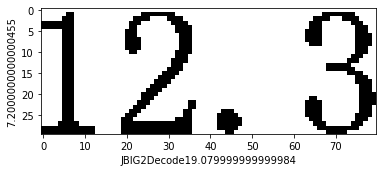

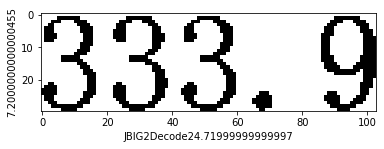

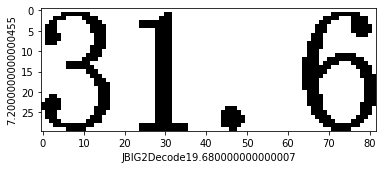

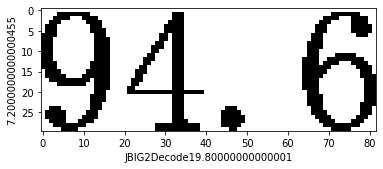

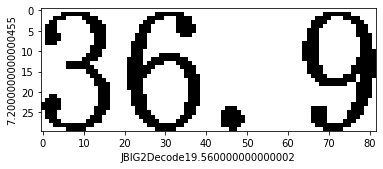

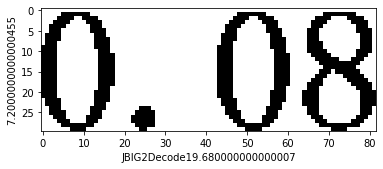

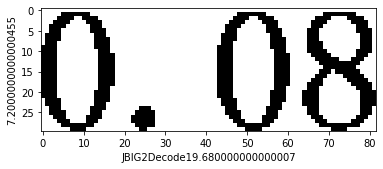

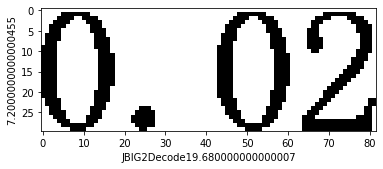

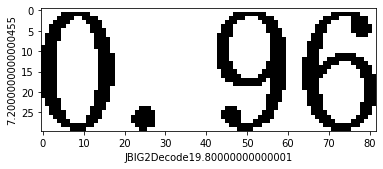

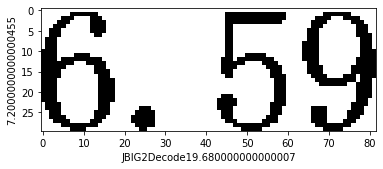

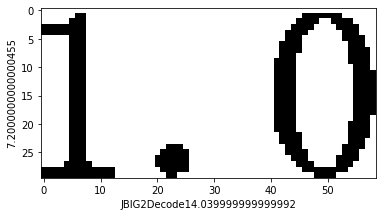

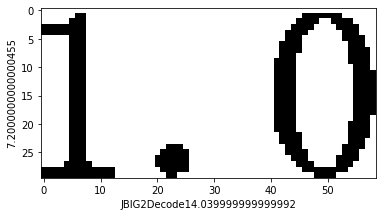

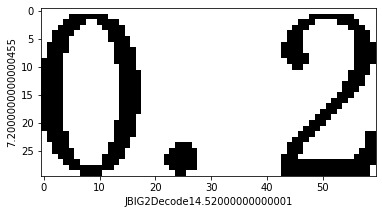

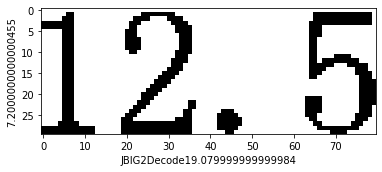

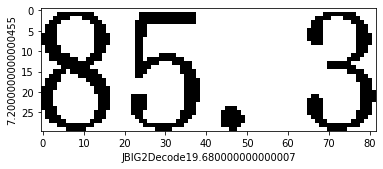

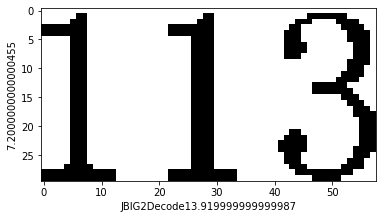

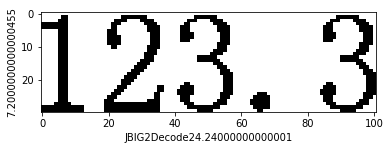

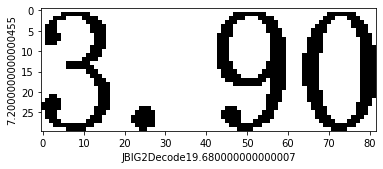

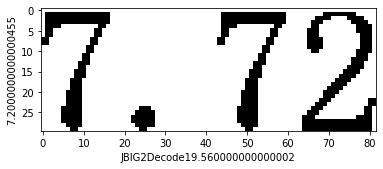

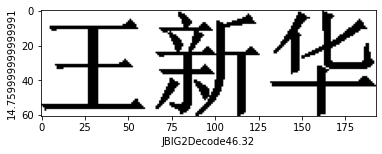

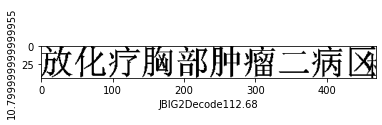

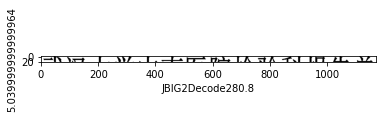

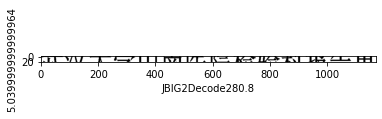

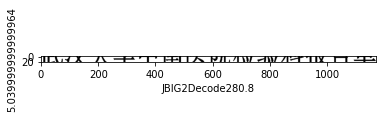

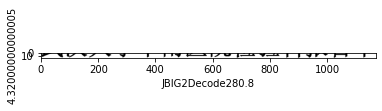

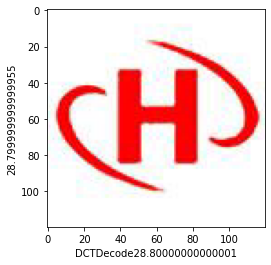

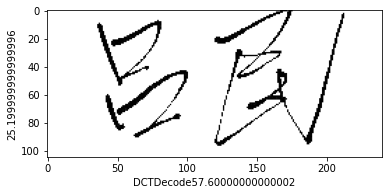

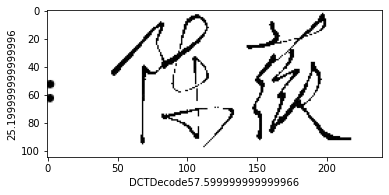

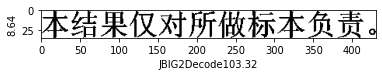

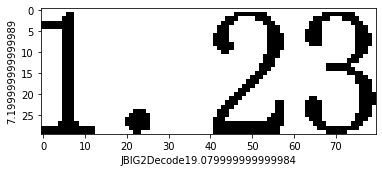

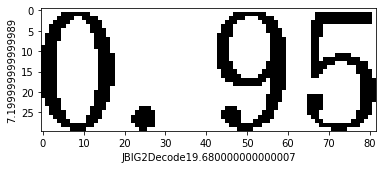

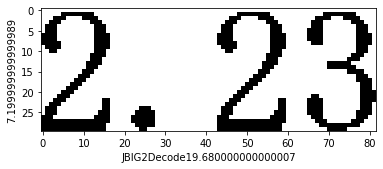

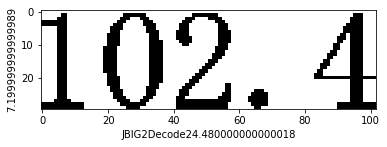

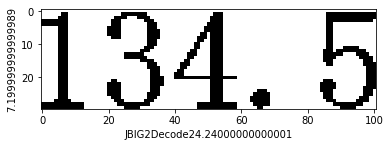

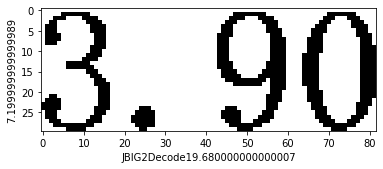

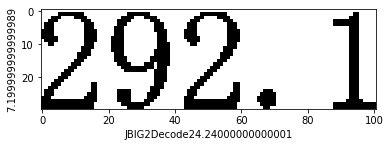

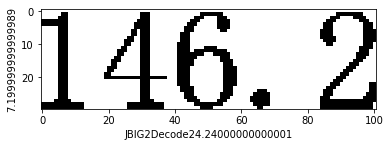

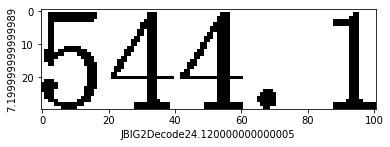

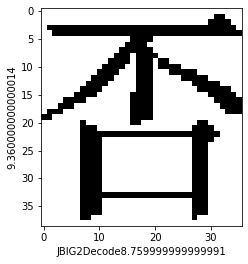

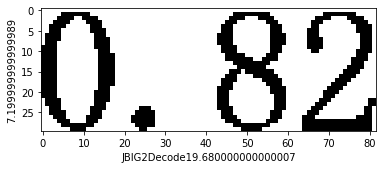

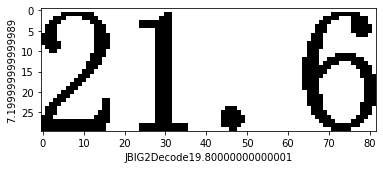

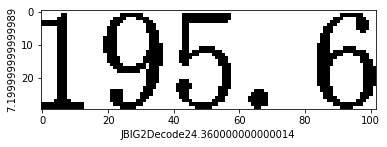

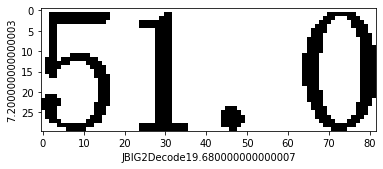

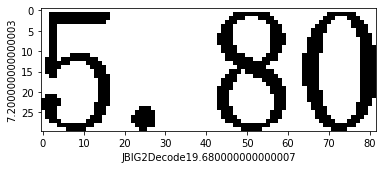

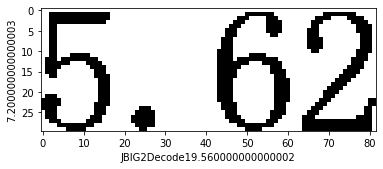

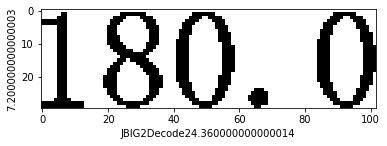

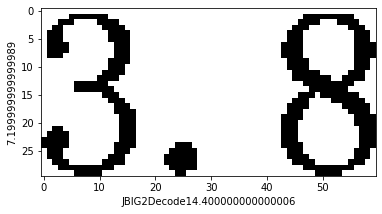

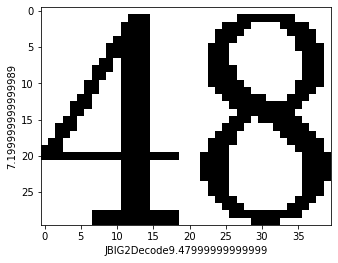

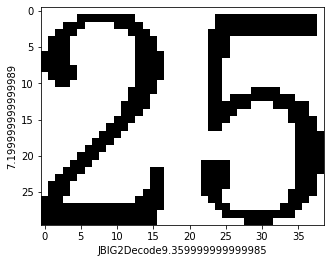

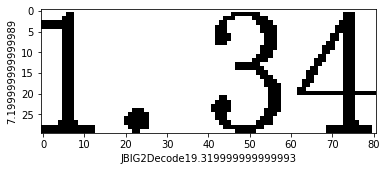

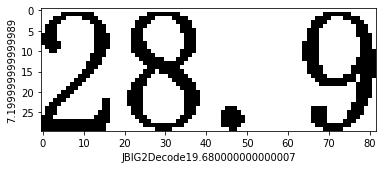

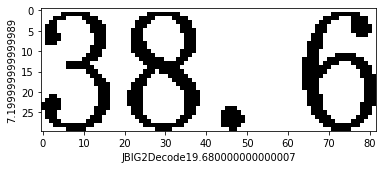

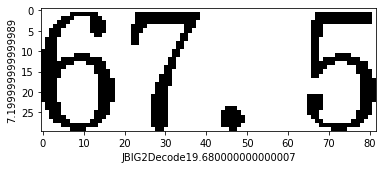

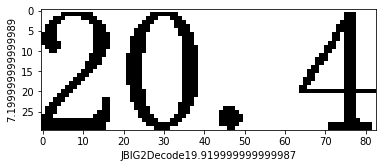

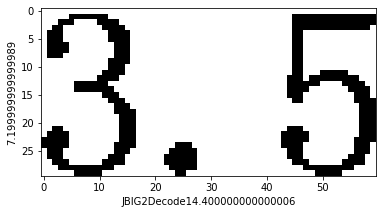

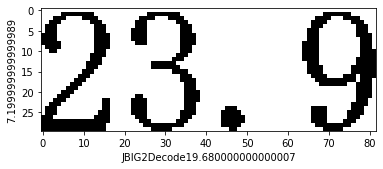

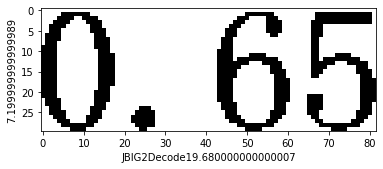

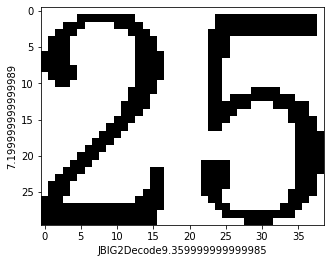

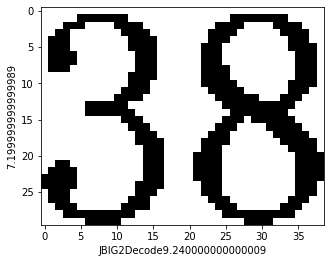

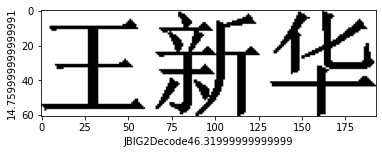

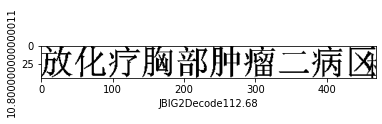

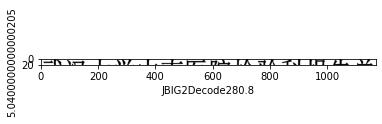

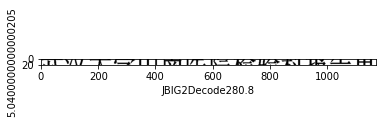

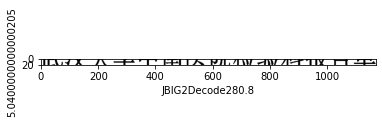

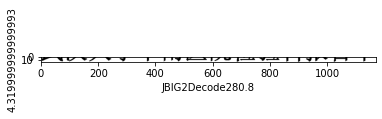

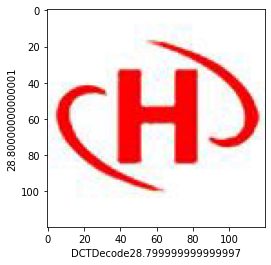

In [35]:
ob = page.objects
ob_image = ob['image']
ii = 1
for ob_i in ob_image:
    croprect = (ob_i['x0']*iw/pw,ob_i['top']*iw/pw,ob_i['x1']*iw/pw,ob_i['bottom']*iw/pw)
    icrop = pilimg.crop(croprect)
    # print(ob_i['width'],ob_i['height'])
    plt.figure()
    plt.imshow(icrop)
    plt.ylabel(ob_i['height'])
    plt.xlabel(ob_i['stream'].attrs['Filter'].name + str(ob_i['width']))
    ii = ii + 1 

In [36]:
ob_char = ob['char']
for ob in ob_char:
    print(ob['text'], end='')

备    注：检验者：审核者：接收时间：报告时间：2018-06-16 09:37:462018-06-16 10:27:13采集时间：检验时间：2018-06-15 11:28:142018-06-16 10:16:49平均血小板体积MPV6--12fL红细胞分布宽度RDW10.1--16.0%平均血红蛋白浓度MCHC316--354g/L平均血红蛋白含量MCH27--34pg平均红细胞体积MCV82--100fL红细胞压积HCT35--45%嗜碱细胞绝对值BASO#↑0--0.0610⁹/L嗜酸细胞绝对值EO#0.02--0.5210⁹/L单核细胞绝对值MONO#↓0.1--0.610⁹/L淋巴细胞绝对值LYMPH#↓1.1--3.210⁹/L中性粒细胞绝对值NEUT#↑1.8--6.310⁹/L嗜碱细胞百分比BASO%0--1%嗜酸细胞百分比EO%0.4--8%单核细胞百分比MONO%↓3--10%淋巴细胞百分比LYMPH%↓20--50%中性粒细胞百分比NEUT%↑40--75%血小板PLT↓125--35010⁹/L血红蛋白HGB115--150g/L红细胞RBC3.8--5.110¹²/L白细胞WBC3.5--9.510⁹/L17性别：姓名：女患者编号：科    室：床    号：正常样本状态：0001186421样本类型：开立医生：诊断：陈刚1006446280条 码 号：血常规分析(紫管2ml)结果结果项目名称项目名称参考范围参考范围50编码编码年龄：岁单位单位胸腺癌 为肿瘤化学治疗疗程全血检查项目：样本号：LJ_BeckmanDXH800A10358检验仪器：审核者：检验者：备    注：检验时间：采集时间：接收时间：报告时间：2018-06-15 07:562018-06-15 12:042018-06-14 14:022018-06-15 10:40磷(P)Phos0.85--1.51mmol/L镁(Mg++)Mg0.85--1.15mmol/L钙(Ca++)Ca2.11--2.52mmol/L氯(Cl-)Cl99--110mmol/L钠(Na+)Na↓137--147mmol/L钾(K+)K3.5--5.3mmol/LB因子（B）B100--400mg/L补体C1qC1q↓159--233mg/L唾液酸(SA)SA456--754mg/L是否

In [38]:

for ob in ob_char:
    print(ob['text'],",",ob['x0'],",",ob['y0'],",",ob['x1'],",",ob['y1'])
    

备 , 17.64 , 496.6284 , 28.08 , 507.0684
  , 28.08 , 496.6284 , 33.3 , 507.0684
  , 33.36 , 496.6284 , 38.58 , 507.0684
  , 38.64 , 496.6284 , 43.86 , 507.0684
  , 43.92 , 496.6284 , 49.14 , 507.0684
注 , 49.2 , 496.6284 , 59.64 , 507.0684
： , 59.64 , 496.6284 , 70.08 , 507.0684
检 , 343.8 , 484.38840000000005 , 354.24 , 494.82840000000004
验 , 354.24 , 484.38840000000005 , 364.68 , 494.82840000000004
者 , 364.68 , 484.38840000000005 , 375.12 , 494.82840000000004
： , 375.12 , 484.38840000000005 , 385.56 , 494.82840000000004
审 , 448.92 , 485.1084 , 459.36 , 495.5484
核 , 459.36 , 485.1084 , 469.8 , 495.5484
者 , 469.8 , 485.1084 , 480.24 , 495.5484
： , 480.24 , 485.1084 , 490.68 , 495.5484
接 , 172.44 , 484.38840000000005 , 182.88 , 494.82840000000004
收 , 182.88 , 484.38840000000005 , 193.32 , 494.82840000000004
时 , 193.32 , 484.38840000000005 , 203.76 , 494.82840000000004
间 , 203.76 , 484.38840000000005 , 214.2 , 494.82840000000004
： , 214.2 , 484.38840000000005 , 224.64 , 494.82840000000004
报

In [56]:
ii = 0
for ob in ob_image:
    ob_image[ii]['text'] = 'text'
    ii = ii + 1
print(ob_image[0])
print(type(ob_image))
oball = []
oball.extend(ob_char)
oball.extend(ob_image)
for ob in oball:
    print(ob['text'],end='')

{'x0': 379.44, 'y0': 478.29, 'x1': 437.04, 'y1': 503.49, 'width': 57.60000000000002, 'height': 25.19999999999999, 'name': 'IM7', 'stream': <PDFStream(7): raw=16154, {'BitsPerComponent': 8, 'ColorSpace': /'DeviceRGB', 'Filter': /'DCTDecode', 'Height': 210, 'Length': 16154, 'Mask': <PDFObjRef:8>, 'Subtype': /'Image', 'Type': /'XObject', 'Width': 480}>, 'srcsize': (480, 210), 'imagemask': None, 'bits': 8, 'colorspace': [/'DeviceRGB'], 'object_type': 'image', 'page_number': 1, 'top': 338.4, 'bottom': 363.59999999999997, 'doctop': 338.4, 'text': 'text'}
<class 'list'>
备    注：检验者：审核者：接收时间：报告时间：2018-06-16 09:37:462018-06-16 10:27:13采集时间：检验时间：2018-06-15 11:28:142018-06-16 10:16:49平均血小板体积MPV6--12fL红细胞分布宽度RDW10.1--16.0%平均血红蛋白浓度MCHC316--354g/L平均血红蛋白含量MCH27--34pg平均红细胞体积MCV82--100fL红细胞压积HCT35--45%嗜碱细胞绝对值BASO#↑0--0.0610⁹/L嗜酸细胞绝对值EO#0.02--0.5210⁹/L单核细胞绝对值MONO#↓0.1--0.610⁹/L淋巴细胞绝对值LYMPH#↓1.1--3.210⁹/L中性粒细胞绝对值NEUT#↑1.8--6.310⁹/L嗜碱细胞百分比BASO%0--1%嗜酸细胞百分比EO%0.4--8%单核细胞百分比MONO%↓3--10%淋巴细胞百分比LYMPH%↓20--50%中

In [57]:
def oblist2txt(oball):
    obtext = ''
    oba = oball
    oba.sort(key = lambda x:x['y0']+x['y1'], reverse = True)
    obtext = ''
    line = []
    ii = -1
    while(len(oba) > 0):
        ob0 = oba[0]
        ii = ii + 1
        if ii ==0:
            line.append(ob0)
            # y0 = ob[0]['y0']
            oba.remove(ob0)

            # print('line:test')
        else:
            if(len(oba) > 1):
                ob1 = oba[1]
                ob0center = ob0['y1'] + ob0['y0']
                ob1center = ob1['y1'] + ob1['y0']
                if(ob0center - ob1center < 5):
                    line.append(ob0)
                    oba.remove(ob0)
                else:
                    line.append(ob0)
                    oba.remove(ob0)
                    obtext = obtext.join(sortline(line))
                    ii = -1
                    line = []                    
            else:
                break # 最后面一个元素是‘本结果仅对所做标本负责’ pass 
    return obtext


# 将一行字典列表转成为文本，间隔远的字符间加逗号
def sortline(line):
    txt =''
    line.sort(key = lambda x:x['x0']+x['x1'], reverse = False)
    ii = 0
    while(len(line) >0):
        # if line[0]['text'] == '：':
        #     line[0]['text'] = '：,'
        if ii == 0:
            txt = line[0]['text']
            line.remove(line[0])
            ii = ii + 1
        else:
            if(len(line) > 1):
                # 如果相距远，加逗号
                if line[1]['x0'] - line[0]['x1'] > 1:
                    txt = txt + line[0]['text'] + ','
                    line.remove(line[0])
                # 如果后一个字符盖着前一个字符一半，加逗号
                elif line[0]['x1']-line[1]['x0']> 0.2:
                    txt = txt + line[0]['text'] + ','
                    line.remove(line[0])
                else: # if line[1]['x0'] - line[0]['x1'] >= 0:
                    txt = txt + line[0]['text']
                    line.remove(line[0])
                # elif line[1]['x0'] - line[0]['x1'] < 0:
            else:
                txt = txt.join(line[0]['text'])
                break

    txt = txt + '\n' # 末尾加换行
    return txt


In [58]:
obtext = oblist2txt(oball)
print(obtext)

MemoryError: 

In [6]:
# get 区域图像 use pymupdf
import fitz

pdf_path = './tmp/t1/0001186421.pdf'
pdf = fitz.open(pdf_path)
page = pdf[0]
def getRectImg(page,zoom_x,zoom_y,rotate_angle = 0, clip_roi=None):
    '''
    
    '''
    trans = fitz.Matrix(zoom_x,zoom_y).preRotate(rotate_angle)
    if clip_roi is not None:
        rect = page.rect
    